In [2]:
import torch
# from segment_anything import SamPredictor, sam_model_registry
from mobile_sam import SamPredictor, sam_model_registry
from torch.nn.functional import threshold, normalize
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import cv2
import os
import numpy as np
import random
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

### 기본설정

In [3]:
config = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'base_path': 'd:/swdacon/open20', # change relative path of data
    'train_data': 'zeroto20.csv', # change train data csv name
    'test_data': 'test20.csv', # change test data csv name
    'seed': 42,
    'valid_size': 0.3,
    'early_stopping': 10,
    'train' : {
       'batch_size' : 1,
       'num_workers': 0,
       'epochs': 100,
       'lr': 1e-3,
       'wd':0  ## weight decay
    },
    'inference' : {
       'batch_size' : 1,
       'num_workers': 0,
       'threshold': 0.35,
    },
}

In [4]:
sam_model = sam_model_registry['vit_t'](checkpoint='d:\swdacon\MobileSAM-master\MobileSAM-master\weights/mobile_sam.pt')
# sam_model = sam_model_registry['vit_h'](checkpoint='d:/swdacon/segment-anything/checkpoints/sam_vit_h_4b8939.pth')
# sam_model = sam_model_registry['vit_h'](checkpoint='d:/swdacon/sam-hq/checkpoints/sam_hq_vit_h.pth')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
sam_model = sam_model_registry['vit_t'](checkpoint='d:/swdacon/0711sam.pt')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# 시드 고정 함수
def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

### dataset

In [7]:
# from segment_anything.utils.transforms import ResizeLongestSide
from mobile_sam.utils.transforms import ResizeLongestSide
from collections import defaultdict

In [8]:
class CustomDataset(Dataset):
    def __init__(self, img_paths, mask_rles = None,infer=False,augmentation=None):
        self.img_paths = img_paths
        self.mask_rles = mask_rles
        self.infer = infer
        self.transform = ResizeLongestSide(sam_model.image_encoder.img_size)
        self.augmentation = augmentation
    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        transformed_data = defaultdict(dict)
        img_path = self.img_paths.iloc[idx]
        image = cv2.imread(config['base_path']+img_path[1:])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.augmentation:
            augmented = self.augmentation(image=image)
            image = augmented['image']
        input_image = self.transform.apply_image(image)
        input_image_torch = torch.as_tensor(input_image, device=device)
        transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]
        
        input_image = sam_model.preprocess(transformed_image)
        original_image_size = image.shape[:2]
        input_size = tuple(transformed_image.shape[-2:])
        
        transformed_data['image'] = input_image
        transformed_data['input_size'] = input_size
        transformed_data['original_image_size'] = original_image_size
        with torch.no_grad():
            image_embedding = sam_model.image_encoder(input_image)
            
        if self.infer:
            return transformed_data,image_embedding
        mask_rle = self.mask_rles.iloc[idx]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1])) ## shape 바뀌어야 하는지 확인
        if self.augmentation:
            augmented = self.augmentation(image=image, mask=mask)
            mask = augmented['mask']
        # gt_mask_resized = torch.from_numpy(np.resize(mask, (1, 1, mask.shape[0], mask.shape[1]))).to(device)
        # gt_binary_mask = torch.as_tensor(gt_mask_resized > 0, dtype=torch.float32)
        gt_binary_mask = torch.as_tensor(mask).to(device)
        
        return transformed_data, image_embedding,gt_binary_mask

In [9]:
train_df = pd.read_csv(f"{config['base_path']}/{config['train_data']}")
train, val = train_test_split(train_df, test_size=config['valid_size'], random_state=config['seed'])
print("train: ", len(train), "   valid: ", len(val))

train:  14    valid:  6


In [10]:
import albumentations as A
# from albumentations.pytorch import ToTensorV2

In [11]:
custom_transform = {
    'train':A.Compose([
        A.augmentations.crops.transforms.RandomCrop(224,224,p=1.0),
        # A.Normalize(),
        # ToTensorV2()
    ]),
    'valid':A.Compose([
        A.augmentations.crops.transforms.CenterCrop(224,224,p=1.0),
        # A.Normalize(),
        # ToTensorV2()
    ]),
    'test': A.Compose([
        # A.Normalize(),
        # ToTensorV2()
    ]),}

In [12]:
fix_seed(config['seed'])

train_dataset = CustomDataset(img_paths=train['img_path'], mask_rles=train['mask_rle'],augmentation = custom_transform['train'])
train_dataloader = DataLoader(train_dataset, batch_size=config['train']['batch_size'], shuffle=True, num_workers=config['train']['num_workers'])

valid_dataset = CustomDataset(img_paths=val['img_path'], mask_rles=val['mask_rle'],augmentation = custom_transform['valid'])
valid_dataloader = DataLoader(valid_dataset , batch_size=config['train']['batch_size'], shuffle=True, num_workers=config['train']['num_workers'])

### train/vali

In [27]:
def validation(config, criterion, valid_loader):
    sam_model.eval()
    valid_loss = 0
    sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                points=None,
                boxes=None,
                masks=None,
            )
    with torch.no_grad():
        for transformed_datas,image_embedding,gt_masks in tqdm(valid_loader):
            # input_image = transformed_datas['image'].to(device)
            input_size = transformed_datas['input_size']
            original_image_size = transformed_datas['original_image_size']
            gt_masks = gt_masks.to(config['device'])

            pred_masks=[]
            for i in range(len(gt_masks)):
                low_res_masks, iou_predictions = sam_model.mask_decoder(
                    image_embeddings=image_embedding[i],
                    image_pe=sam_model.prompt_encoder.get_dense_pe(),
                    sparse_prompt_embeddings=sparse_embeddings,
                    dense_prompt_embeddings=dense_embeddings,
                    multimask_output=False,
                )
                upscaled_masks = sam_model.postprocess_masks(low_res_masks, (input_size[0][i],input_size[1][i]), (original_image_size[0][0],original_image_size[1][0])).to(device)
                # upscaled_masks*=-1
                binary_mask = normalize(threshold(upscaled_masks, -1, 0))
                # binary_mask = binary_mask.tolist()
                # pred_masks.append(binary_mask)
                # pred_masks=torch.as_tensor(pred_masks).to(config['device'])
                # pred_masks = pred_masks.squeeze()
                # loss = criterion(pred_masks[i], gt_masks[i])
                binary_mask = torch.as_tensor(binary_mask.tolist()).to(config['device']).squeeze()
                loss = criterion(binary_mask, gt_masks[i])
            valid_loss += loss.item()

    return valid_loss/len(valid_loader)

In [28]:
def train(config, train_loader, valid_loader):
    sam_model.to(config['device'])
    es_count = 0
    min_val_loss = float('inf')
    best_model = None
    optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(),lr=config['train']['lr']) 
    criterion = torch.nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, min_lr=1e-8, verbose=True)
    sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                points=None,
                boxes=None,
                masks=None,
            )
    # training loop
    for epoch in range(config['train']['epochs']):
        sam_model.train()
        epoch_loss = 0
        for transformed_datas,image_embedding,gt_masks in tqdm(train_loader):
            input_image = transformed_datas['image'].to(config['device'])
            input_size = transformed_datas['input_size']
            original_image_size = transformed_datas['original_image_size']
            gt_masks = gt_masks.to(config['device'])
            pred_masks=[]
            for i in range(len(gt_masks)):
                low_res_masks, iou_predictions = sam_model.mask_decoder(
                    image_embeddings=image_embedding[i],
                    image_pe=sam_model.prompt_encoder.get_dense_pe(),
                    sparse_prompt_embeddings=sparse_embeddings,
                    dense_prompt_embeddings=dense_embeddings,
                    multimask_output=False,
                )
                upscaled_masks = sam_model.postprocess_masks(low_res_masks, (input_size[0][i],input_size[1][i]), (original_image_size[0][0],original_image_size[1][0])).to(device)
                # upscaled_masks*=-1
                
                binary_mask = normalize(threshold(upscaled_masks, -1, 0))
                # print(upscaled_masks,binary_mask)
                # binary_mask = binary_mask.tolist()
                # pred_masks.append(binary_mask)
                # pred_masks=torch.as_tensor(pred_masks).to(config['device'])
                # pred_masks = pred_masks.squeeze()
                # loss = criterion(pred_masks[i], gt_masks[i])
                binary_mask = torch.as_tensor(binary_mask.tolist()).to(config['device']).squeeze()
                loss = criterion(binary_mask, gt_masks[i])
                optimizer.zero_grad()
                loss.requires_grad_(True)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
        val_loss = validation(config, criterion, valid_loader)
        es_count += 1
        scheduler.step(val_loss)
        if min_val_loss > val_loss:
            es_count = 0
            min_val_loss = val_loss
            best_model = sam_model
            best_epoch = epoch
            print(f"Epoch [{epoch + 1}] New Minimum Valid Loss!")
        
        if es_count == config['early_stopping']:
            print(f"EARLY STOPPING COUNT: {config['early_stopping']} BEST EPOCH: {best_epoch}")
            return best_model
        
        print(f'Epoch {epoch+1}, Train Loss: {epoch_loss/len(train_loader)}', 'Valid Loss:', val_loss, 'ES Count:', es_count)
        print("------------------------------------------------------------------------------------")
    
    print(f"EARLY STOPPING COUNT에 도달하지 않았습니다! \nEARLY STOPPING COUNT: {config['early_stopping']} BEST EPOCH: {best_epoch}")
    return best_model

In [29]:
best_model = train(config, train_dataloader, valid_dataloader)

100%|██████████| 6/6 [00:00<00:00,  7.14it/s]


Epoch [1] New Minimum Valid Loss!
Epoch 1, Train Loss: 0.16583340827907836 Valid Loss: 0.6160647766664624 ES Count: 0
------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:00<00:00,  7.19it/s]


Epoch [2] New Minimum Valid Loss!
Epoch 2, Train Loss: 0.11410975935203689 Valid Loss: 0.5720065317388313 ES Count: 0
------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:00<00:00,  7.14it/s]


Epoch 3, Train Loss: 0.2752439881400538 Valid Loss: 0.7739224433898926 ES Count: 1
------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:00<00:00,  7.17it/s]


Epoch 4, Train Loss: 0.17262663585799082 Valid Loss: 0.6264548599720001 ES Count: 2
------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:00<00:00,  7.18it/s]


Epoch 5, Train Loss: 0.19191730075648852 Valid Loss: 0.6789899443586668 ES Count: 3
------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:00<00:00,  7.20it/s]


Epoch 6, Train Loss: 0.2674884357256815 Valid Loss: 0.6377517618238926 ES Count: 4
------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:00<00:00,  7.20it/s]


Epoch 00007: reducing learning rate of group 0 to 5.0000e-04.
Epoch 7, Train Loss: 0.26579154810834943 Valid Loss: 0.5980647935842475 ES Count: 5
------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:00<00:00,  7.21it/s]


Epoch 8, Train Loss: 0.3345409771926435 Valid Loss: 0.6283648119618496 ES Count: 6
------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:00<00:00,  7.23it/s]


Epoch 9, Train Loss: 0.21788873942568898 Valid Loss: 0.607993188003699 ES Count: 7
------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:00<00:00,  7.20it/s]


Epoch 10, Train Loss: 0.1935786016817604 Valid Loss: 0.6406482371191183 ES Count: 8
------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:00<00:00,  7.24it/s]


Epoch 11, Train Loss: 0.14607581083795854 Valid Loss: 0.6686197717984518 ES Count: 9
------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:00<00:00,  7.21it/s]

Epoch 00012: reducing learning rate of group 0 to 2.5000e-04.
EARLY STOPPING COUNT: 10 BEST EPOCH: 1


### inference

In [169]:
test_df = pd.read_csv(f"{config['base_path']}/{config['test_data']}")

In [170]:
class TestDataset():
    def __init__(self, img_paths):
        self.img_paths = img_paths
    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths.iloc[idx]
        image = cv2.imread(config['base_path']+img_path[1:])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

In [59]:
fix_seed(config['seed'])

test_dataset = TestDataset(img_paths=test_df['img_path'])
test_dataloader = DataLoader(test_dataset, batch_size=config['inference']['batch_size'], shuffle=False, num_workers=config['inference']['num_workers'])

In [171]:
fix_seed(config['seed'])

test_dataset = CustomDataset(img_paths=test_df['img_path'],infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=config['inference']['batch_size'], shuffle=False, num_workers=config['inference']['num_workers'])

In [137]:
def inference(config,model, test_loader):
    model = model.to(device)
    inference_model = SamPredictor(model)
    with torch.no_grad():
        model.eval()
        result = []
        for images in tqdm(test_loader):
            pred_masks=[]
            for i in range(len(images)):
                inference_model.set_image(images[i].detach().numpy())
                prediction,_,_ = inference_model.predict(
                    point_coords=None,
                    box=None,
                    multimask_output=False
                )
                pred_masks.append(1-prediction)
            for i in range(len(images)):
                mask_rle = rle_encode(pred_masks[i])
                if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
                    result.append(-1)
                else:
                    result.append(mask_rle)
    return result

In [173]:
def test(config, model, test_loader):
    model = model.to(device)
    with torch.no_grad():
        result = []
        model.eval()
        for transformed_datas,image_embedding,sparse_embeddings,dense_embeddings in tqdm(test_loader):
            input_image = transformed_datas['image'].to(device)
            input_size = transformed_datas['input_size']
            original_image_size = transformed_datas['original_image_size']
            for i in range(len(input_image)):
                low_res_masks, iou_predictions = sam_model.mask_decoder(
                    image_embeddings=image_embedding[i],
                    image_pe=sam_model.prompt_encoder.get_dense_pe(),
                    sparse_prompt_embeddings=sparse_embeddings[i],
                    dense_prompt_embeddings=dense_embeddings[i],
                    multimask_output=False,
                )
                upscaled_masks = sam_model.postprocess_masks(low_res_masks, (input_size[0][i],input_size[1][i]), (original_image_size[0][0],original_image_size[1][0])).to(device)
                # upscaled_masks*=-1
                # binary_mask = normalize(threshold(upscaled_masks, 3, 0))
                binary_mask = normalize(threshold(upscaled_masks, 0, 0))
                binary_mask = binary_mask.tolist()
                # binary_mask = not binary_mask
                mask_rle = rle_encode(np.array(binary_mask))
                if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
                    result.append(-1)
                else:
                    result.append(mask_rle)

    return result

In [174]:
inference_result = test(config, best_model, test_dataloader)

100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


In [106]:
print(len(inference_result))

20


In [140]:
submit = pd.read_csv(f"{config['base_path']}/sample_submission.csv")
submit['mask_rle'] = inference_result
submit.to_csv(f"{config['base_path']}/{'0711test.csv'}", index=False)

In [176]:
submit = pd.read_csv(f"{config['base_path']}/submit20.csv")
submit['mask_rle'] = inference_result
submit.to_csv(f"{config['base_path']}/{'0711test.csv'}", index=False)

In [141]:
def submission_viewer(test_csv, submit_csv, img_num, base_path = config['base_path'], is_colab = False):
    """
    white -> 건물 black -> 배경
    1. Local에서 사용 시 test_csv, submit_csv, img_num만 입력
    2. colab에서 사용 시 아래 사항을 입력
    base_path = colab_base
    is_colab = True
    """
    mask_rle = submit_csv.iloc[img_num, 1]
    image_path = test_csv.iloc[img_num, 1]
    if is_colab:
        image = cv2.imread(image_path)
    else:
        image = cv2.imread(base_path + image_path[1:])
    mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))
    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(image)
    ax1.set_title('image')
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(mask,cmap='gray')
    ax2.set_title('mask')
    plt.show()

In [ ]:
last_submit = pd.read_csv(f"{config['base_path']}/0711test.csv")
submission_viewer(test_df, last_submit, 15)
submission_viewer(test_df, last_submit,16)
submission_viewer(test_df, last_submit, 14)

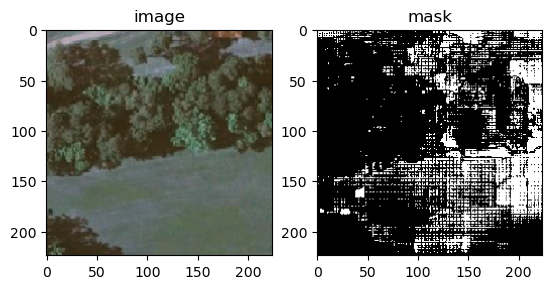

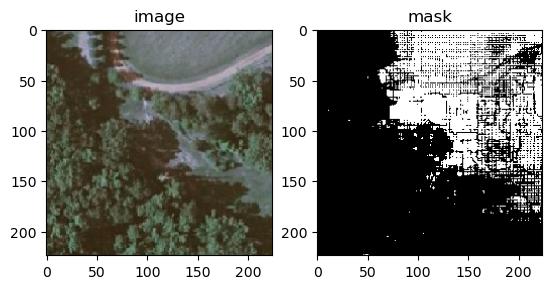

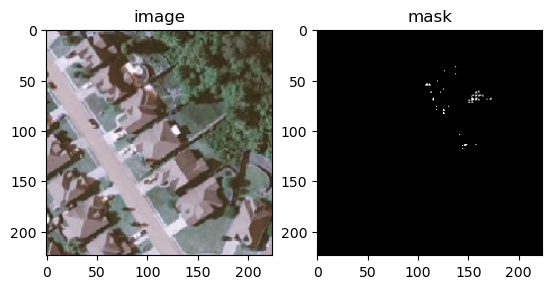

In [177]:
last_submit = pd.read_csv(f"{config['base_path']}/0711test.csv")
submission_viewer(test_df, last_submit, 15)
submission_viewer(test_df, last_submit,16)
submission_viewer(test_df, last_submit, 14)

In [143]:
torch.save(best_model, f"{config['base_path']}/{'0712sam.pt'}")